In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import pandas as pd
import scipy.io
import numpy as np
import copy


import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

from tensorflow import keras
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install watermark
%load_ext watermark

%watermark --iversions 

numpy     : 1.21.6
matplotlib: 3.2.2
tensorflow: 2.8.0+zzzcolab20220506162203
h5py      : 3.1.0
keras     : 2.8.0
PIL       : 7.1.2
sklearn   : 0.0
google    : 2.0.3
scipy     : 1.4.1
IPython   : 5.5.0
pandas    : 1.3.5
csv       : 1.0



#Healthy Unhealthy Classification

In [ ]:
data = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/dataset/healthy_unhealthy1.csv', delimiter=',')

In [ ]:
from sklearn.model_selection import train_test_split 

## healthy 0 unhealthy 1
x_bal = data[:,0:1024]
y_bal = data[:,-1]

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, y_bal, test_size = 0.2, shuffle = True)

##1D CNN

In [ ]:
# GRADED FUNCTION: convolutional_model
import tensorflow as tf
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from time import time

def convolutional_model(input_shape, x_train,y_train,test_data):
    start = time()
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV1D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv1D(filters=32,
                    kernel_size=15,
                    strides=1,
                    padding='same')(input_img) 
    Z11 = tfl.Conv1D(filters=16,
                    kernel_size=7,
                    strides=1,
                    padding='same')(Z1)
    ## RELU
    A1 = tfl.ReLU()(Z11)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool1D(pool_size= 16,
                       padding='same')(A1)


    Z11 = tfl.Conv1D(filters=5,
                    kernel_size=5,
                    strides=1,
                    padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(P1)
    ## RELU
    A1 = tfl.ReLU()(Z11)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool1D(pool_size= 4,
                       padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv1D(filters=8,
                    kernel_size=5,
                    strides=1,
                    padding='same')(P1)
    Z2=tf.nn.dropout(Z2, rate = 0.3)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool1D(pool_size=8,
                       padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer

    op1 = tfl.Dense(units=15,
                       activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(F)

    #op1= tf.nn.dropout(op1, rate=0.4)

    op = tfl.Dense(units=6,
                        activation='relu')(op1)
          
    outputs = tfl.Dense(units=1,
                        activation='sigmoid')(op)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)  

    #compile
    opt = tf.keras.optimizers.Adam( learning_rate=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    #compile
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])
    
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)
    history_m = model.fit(x_train,y_train, epochs=1200, callbacks=[early_stopping], validation_split = 0.2, batch_size = 100, shuffle = True)

    t=time()-start
    print('Total training time:', t)
    history_m.history['time']=t
    
    return model, history_m



##1D CNN with skip connections



In [ ]:
# GRADED FUNCTION: convolutional_model
import tensorflow as tf
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from tensorflow import keras
from time import time

def convolutional_model2(input_shape, x_train,y_train,test_data):
    i = 0
    skips = []
    start = time()
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV1D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z11 = tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same')(input_img)
    Z12  = tfl.BatchNormalization()(Z11)
    Z13 = tfl.ReLU()(Z12)
    skips.append(Z13)


    Z21 = tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same')(Z13)
    Z22  = tfl.BatchNormalization()(Z21)
    Z23 = tfl.ReLU()(Z22)
    Z24 = tfl.Conv1D(filters = 32, kernel_size = 9, strides = 1 , padding = 'same')(Z23)
    skip = skips[i]
    i = i+1
    x = tfl.Concatenate()([Z24, skip])
    skips.append(x)

    
    Z31  = tfl.BatchNormalization()(x)
    Z32  = tfl.ReLU()(Z31)

    #Z1=tf.nn.dropout(Z1, rate = 0.3)
    Z33 = tfl.Conv1D(filters=16,
                    kernel_size=9,
                    strides=1,
                    padding='same')(Z32)
    Z34 = tfl.MaxPooling1D(pool_size = 2 , padding = 'same')(Z33)
    Z35 = tfl.BatchNormalization()(Z34)
    Z36 = tfl.ReLU()(Z35)

    A1 = tfl.Conv1D(filters=16,
                    kernel_size=9,
                    strides=1,
                    padding='same')(Z36)

    Z41 = tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same')(A1)
    Z42  = tfl.BatchNormalization()(Z41)
    Z43 = tfl.ReLU()(Z42)

    skips.append(Z43)


    Z51 = tfl.Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same')(A1)
    Z52  = tfl.BatchNormalization()(Z51)
    Z53 = tfl.ReLU()(Z52)
    Z54 = tfl.Conv1D(filters = 32, kernel_size = 9, strides = 1 , padding = 'same')(Z53)
    skip = skips[2]
    i = i+1
    x = tfl.Concatenate()([Z54, skip])
    skips.append(x)
    
    # x = tfl.Concatenate()([Z37, Z42])
    ## RELU
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.AveragePooling1D(pool_size= 16,
                       padding='same')(x)
    #P1=tf.nn.dropout(P1, rate = 0.3)


    Z1 = tfl.Conv1D(filters=32,
                    kernel_size=9,
                    strides=1,
                    padding='same')(P1)
    #Z1=tf.nn.dropout(Z1, rate = 0.3)
    Z11 = tfl.Conv1D(filters=12,
                    kernel_size=7,
                    strides=1,
                    padding='same')(Z1)
    ## RELU
    A1 = tfl.ReLU()(Z11)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPooling1D(pool_size= 8,
                       padding='same')(A1)
   
    ## CONV2D: 16 filters 3x3, stride 1, padding 'SAME'
    Z2 = tfl.Conv1D(filters=16,
                    kernel_size=5,
                    strides=1,
                    padding='same')(P1)
    #Z2=tf.nn.dropout(Z2, rate = 0.4)
    Z21 = tfl.Conv1D(filters=8,
                    kernel_size=3,
                    strides=1,
                    padding='same')(Z2)
    ## RELU
    A2 = tfl.ReLU()(Z21)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPooling1D(pool_size=4,
                       padding='same')(A2)

    Z3 = tfl.Conv1D(filters=8,
                    kernel_size=5,
                    strides=1,
                    padding='same')(P2)
    Z3=tf.nn.dropout(Z3, rate = 0.2)
    Z31 = tfl.Conv1D(filters=4,
                    kernel_size=3,
                    strides=1,
                    padding='same')(Z3)
    ## RELU
    A3 = tfl.ReLU()(Z31)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P3 = tfl.MaxPooling1D(pool_size= 4,
                       padding='same')(A3)

    ## FLATTEN
    F = tfl.Flatten()(P3)
    ## Dense layer
    op = tfl.Dense(units=55,
                        activation='relu')(F)

    op1 = tfl.Dense(units=16,
                        activation='relu')(F)

          
    outputs = tfl.Dense(units=1,
                        activation='sigmoid')(op1)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)

    #compile
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2)
    history_m = model.fit(x_train,y_train, epochs=150, validation_split =0.2, callbacks = [early_stopping], batch_size = 100, shuffle = True)

    t=time()-start
    print('Total training time:', t)
    history_m.history['training_time']=t

    # filepath="/content/drive/MyDrive/ML/Disease_classification/weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    return model, history_m

In [ ]:
conv_model, history_m = convolutional_model2((1024,1), x_train1, y_train1, (x_test1, y_test1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 1024, 32)     0           ['batch_normalization[0][0]']

In [ ]:
conv_model.save('/content/drive/MyDrive/ML/H&U_classification/skip/model_v1.h5')
np.save('/content/drive/MyDrive/ML/H&U_classification/skip/ver1_history.npy',history_m)

# save testdata to csv file
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/skip/xtest_data_ver1.csv', x_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/skip/ytest_data_ver1.csv', y_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/skip/xtrain_data_ver1.csv', x_train1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/skip/ytrain_data_ver1.csv', y_train1, delimiter=',')

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model("model_skip_HU (1).h5")


117/117 - 1s - 1s/epoch - 9ms/step
Accuracy: 0.865932
Specificity: 0.844127
Precision: 0.855764
Sensitivity: 0.886842
F1 score: 0.871026
Cohens kappa: 0.731538
ROC AUC: 0.942347
Total Samples Test:  3722
[[1538  284]
 [ 215 1685]]


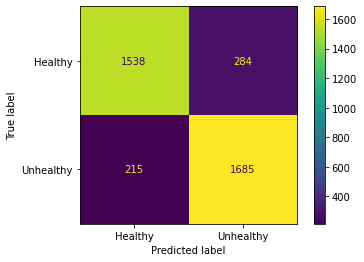

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

prob = model1.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")


#(loss, acc) = conv_model.evaluate(x_test1, y_test1)
#print("Accuracy", acc*100)


# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]
 
cm= metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# sensitivity = tp(tp+fn)
#sensitivity = metrics.specificity_score(y_test1, pred)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall/sensitivity: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = metrics.roc_auc_score(y_test1, prob)
print('ROC AUC: %f' % auc)

print("Total Samples Test: ", np.shape(y_test1)[0])
labels=["Healthy", "Unhealthy"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)      
disp.plot()
plt.savefig('confusion_matrix_healthy_skip.pdf')
print(cm)

##LSTM model

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from time import time

# fix random seed for reproducibility

start = time()
model = Sequential()
model.add(keras.Input(shape=(1024,1)))
model.add(Conv1D(filters=32,
                    kernel_size=7,
                    strides=1,
                    padding='same'))
model.add(Conv1D(filters=16,
                    kernel_size=9,
                    strides=1,
                    padding='same'))
# model.add(MaxPooling1D(pool_size= 16,
                      #  padding='same'))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=8))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((1024,1,1))
print(model.summary())
# model.fit(x_train1, y_train1, epochs=25, batch_size=64)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=2)
history_m = model.fit(x_train1,y_train1, epochs=150, validation_split =0.2, callbacks = [early_stopping], batch_size = 100, shuffle = True)
t=time()-start
print('Total training time:', t)
history_m.history['training_time']=t
# Final evaluation of the model
scores = model.evaluate(x_test1, y_test1, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1024, 32)          256       
                                                                 
 conv1d_10 (Conv1D)          (None, 1024, 16)          4624      
                                                                 
 conv1d_11 (Conv1D)          (None, 1024, 32)          2592      
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 60,773
Trainable params: 60,773
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
60/60 [==========================

In [ ]:
model.save('/content/drive/MyDrive/ML/H&U_classification/lstm/model_vA1.h5')
np.save('/content/drive/MyDrive/ML/H&U_classification/lstm/verA1_history.npy',history_m)

# save testdata to csv file
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/lstm/xtest_data_verA1.csv', x_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/lstm/ytest_data_verA1.csv', y_test1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/lstm/xtrain_data_verA1.csv', x_train1, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML/H&U_classification/lstm/ytrain_data_verA1.csv', y_train1, delimiter=',')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'training_time'])


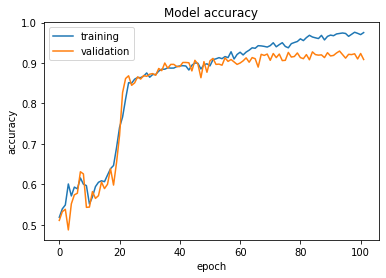

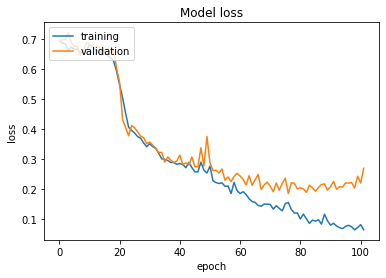

Training accuracy:  97.51344323158264
Validation accuracy:  90.86021780967712


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('acc_healthy.pdf')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('loss_healthy.pdf')
plt.show()


print("Training accuracy: ", history.history['accuracy'][-1]*100)
print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)   

0.9683766840408656


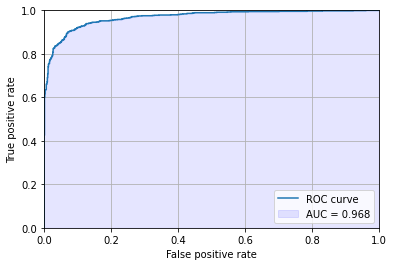

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model1.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('ROC_hea_unhea.pdf')

59/59 - 1s - 786ms/epoch - 13ms/step
Accuracy: 0.914516
Specificity: 0.928726
Precision: 0.927233
Sensitivity: 0.900428
F1 score: 0.913634
Cohens kappa: 0.829050
ROC AUC: 0.968377
Total Samples Test:  1860
[[860  66]
 [ 93 841]]


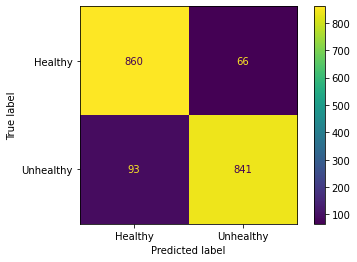

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

prob = model1.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")


#(loss, acc) = conv_model.evaluate(x_test1, y_test1)
#print("Accuracy", acc*100)


# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]
 
cm= metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# sensitivity = tp(tp+fn)
#sensitivity = metrics.specificity_score(y_test1, pred)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall/sensitivity: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = metrics.roc_auc_score(y_test1, prob)
print('ROC AUC: %f' % auc)

print("Total Samples Test: ", np.shape(y_test1)[0])
labels=["Healthy", "Unhealthy"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)      
disp.plot()
plt.savefig('confusion_matrix_healthy_lstm.pdf')
print(cm)

##Inception Model

In [ ]:
# GRADED FUNCTION: convolutional_model
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from time import time


# Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
    conv1 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv2 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv3 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    maxp = MaxPool1D(pool_size=3, strides=1, padding='same')(layer)

    conv2 = Conv1D(f2, 3, activation='relu', padding='same')(conv2)
    conv3 = Conv1D(f3, 5, activation='relu', padding='same')(conv3)
    conv4 = Conv1D(f4, 1, activation='relu', padding='same')(maxp)

    return Concatenate()([conv1, conv2, conv3, conv4])

def build_incep(input_shape,  x_train,y_train,test_data):
    start=time()
    input_signal = Input(shape=input_shape)


    incept = inception_module(input_signal, 16, 32, 64, 16)
    conv = Conv1D(96, 5, activation='relu', padding='same')(incept)
    conv = Conv1D(64, 3, activation='relu', padding='same')(conv)
    gru = GRU(64, return_sequences=True)(conv)

    maxp = MaxPool1D()(gru)

    incept = inception_module(maxp, 8, 16, 32, 8)
    conv = Conv1D(48, 5, activation='relu', padding='same')(incept)
    conv = Conv1D(32, 3, activation='relu', padding='same')(conv)
    gru = GRU(32, return_sequences=True)(conv)

    maxp = MaxPool1D()(gru)

    incept = inception_module(maxp, 2, 4, 8, 2)
    conv = Conv1D(12, 5, activation='relu', padding='same')(incept)
    conv = Conv1D(8, 3, activation='relu', padding='same')(conv)
    gru = GRU(8, return_sequences=True)(conv)

    flat = Flatten()(gru)
    #output1 = Dense(8, activation='relu')(flat)
    output = Dense(1, activation='sigmoid')(flat)


    #if 'model' in globals() or 'model' in locals():
    #    del model

    model = keras.Model(inputs=input_signal, outputs=output)
    model.summary()
    init_weights = model.get_weights()
    
    #plot_model(model, show_shapes=True)

    #compile
    opt = tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    #compile
    model.compile(optimizer = 'adam',
                  loss='binary_crossentropy',
              metrics=['accuracy'])
    
    model.summary()

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=2)
    history_m = model.fit(x_train,y_train, epochs=150, validation_split = 0.2, callbacks=[early_stopping] ,batch_size = 64, shuffle = True)

    t=time()-start
    print('Total training time:', t)
    history_m.history['time']=t
    
    return model, history_m

In [ ]:
conv_model, history = build_incep((1024,1), x_train1, y_train1, (x_test1,y_test1))

## Results

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/ML/H&U_classification/lstm/model_v4.h5')
history=np.load('/content/drive/MyDrive/ML/H&U_classification/lstm/ver4_history.npy',allow_pickle='TRUE').item()

x_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/xtest_data_ver4.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/ytest_data_ver4.csv', delimiter=',')

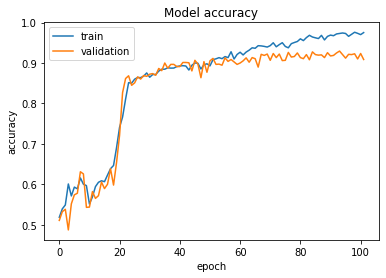

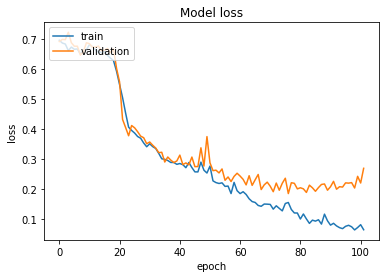

Training accuracy:  97.51344323158264
Validation accuracy:  90.86021780967712
59/59 - 13s - 13s/epoch - 214ms/step
Accuracy: 0.914516
Specificity: 0.928726
Precision: 0.927233
Sensitivity: 0.900428
F1 score: 0.913634
Cohens kappa: 0.829050
ROC AUC: 0.968377
Total Samples Test:  1860
[[860  66]
 [ 93 841]]


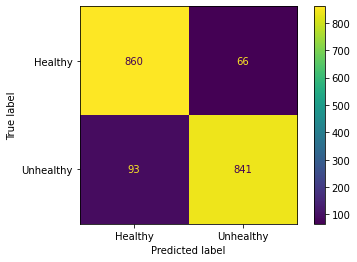

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

# list all data in history
#print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_healthy_unhealthy.pdf')
plt.show()

# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_healthy_unhealthy.pdf')
plt.show()



# print("Training accuracy: ", history.history['accuracy'][-1]*100)
# print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)   
print("Training accuracy: ", history.history['accuracy'][-1]*100)
print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)        

prob = model1.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")


#(loss, acc) = conv_model.evaluate(x_test1, y_test1)
#print("Accuracy", acc*100)


# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]
 
cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# sensitivity = tp(tp+fn)
#sensitivity = metrics.specificity_score(y_test1, pred)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall/sensitivity: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = metrics.roc_auc_score(y_test1, prob)
print('ROC AUC: %f' % auc)

print("Total Samples Test: ", np.shape(y_test1)[0])
labels=["Healthy", "Unhealthy"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)      
disp.plot()
plt.savefig('confusion_matrix_healthy_unhealthy.pdf')
print(cm)

0.9683766840408656


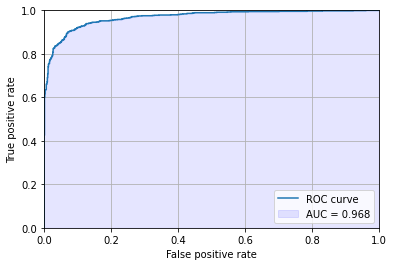

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model1.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('ROC_hea_unhea.pdf')

Actual = Healthy, Prediction = Healthy


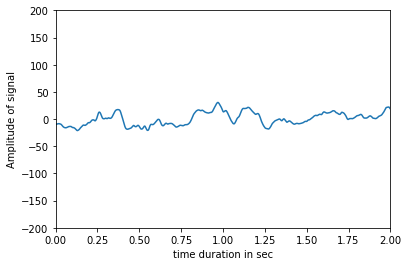

In [ ]:
labels=["Healthy", "Unhealthy"]
index=600
pred = model1.predict(x_test1)

real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print ("Actual = " + act + ", Prediction = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.axis([0, 2, -200, 200])
plt.show()

# Healthy - Unhealthy Classification [Phase B]

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/ML/H&U_classification/lstm/model_vB1.h5')
history=np.load('/content/drive/MyDrive/ML/H&U_classification/lstm/verB1_history.npy',allow_pickle='TRUE').item()

x_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/xtest_data_verB1.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/ytest_data_verB1.csv', delimiter=',')

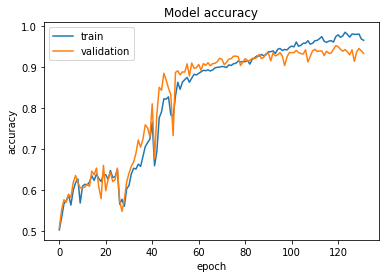

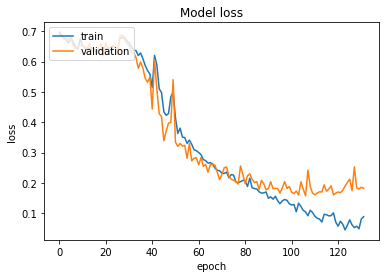

Training accuracy:  96.53897881507874
Validation accuracy:  93.34677457809448
59/59 - 1s - 1s/epoch - 22ms/step
Accuracy: 0.927419
Specificity: 0.961702
Precision: 0.957993
Sensitivity: 0.892391
F1 score: 0.924029
Cohens kappa: 0.854716
ROC AUC: 0.975164
Total Samples Test:  1860
[[904  36]
 [ 99 821]]


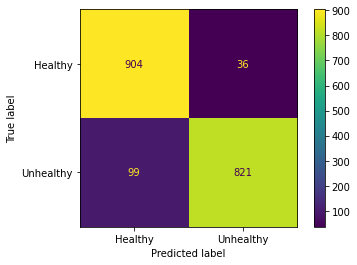

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_healthy_unhealthy.pdf')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_healthy_unhealthy.pdf')
plt.show()

  
print("Training accuracy: ", history.history['accuracy'][-1]*100)
print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)        

prob = model1.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]
 
cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# sensitivity = tp(tp+fn)
#sensitivity = metrics.specificity_score(y_test1, pred)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall/sensitivity: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = metrics.roc_auc_score(y_test1, prob)
print('ROC AUC: %f' % auc)

print("Total Samples Test: ", np.shape(y_test1)[0])
labels=["Healthy", "Unhealthy"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)      
disp.plot()
plt.savefig('confusion_matrix_healthy_unhealthy.pdf')
print(cm)

0.975164199814986


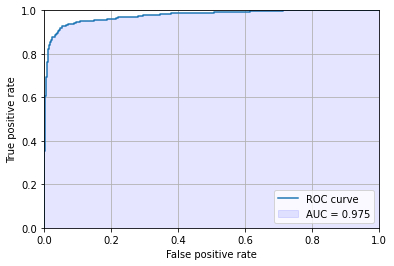

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model1.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('ROC_hea_unhea.pdf')

Actual = Healthy, Prediction = Healthy


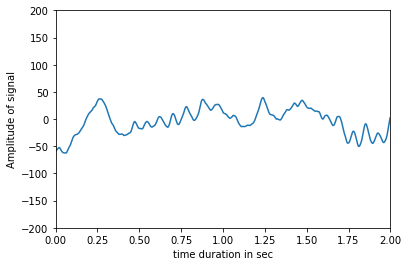

In [ ]:
labels=["Healthy", "Unhealthy"]
index=1000
pred = model1.predict(x_test1)

real = y_test1
prediction = 0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print ("Actual = " + act + ", Prediction = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.axis([0, 2, -200, 200])
plt.show()

# Healthy - Unhealthy Classification [Phase A]

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/ML/H&U_classification/lstm/model_vA1.h5')
history=np.load('/content/drive/MyDrive/ML/H&U_classification/lstm/verA1_history.npy',allow_pickle='TRUE').item()

x_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/xtest_data_verA1.csv', delimiter=',')
y_test1 = np.loadtxt('/content/drive/MyDrive/ML/H&U_classification/lstm/ytest_data_verA1.csv', delimiter=',')

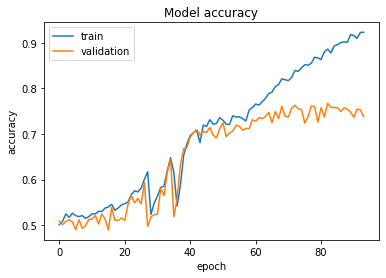

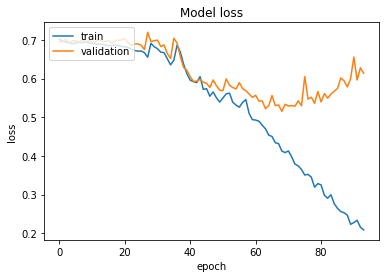

Training accuracy:  92.28830933570862
Validation accuracy:  73.79032373428345
59/59 - 2s - 2s/epoch - 30ms/step
Accuracy: 0.733871
Specificity: 0.706202
Precision: 0.726166
Sensitivity: 0.760893
F1 score: 0.743124
Cohens kappa: 0.467363
ROC AUC: 0.800870
Total Samples Test:  1860
[[649 270]
 [225 716]]


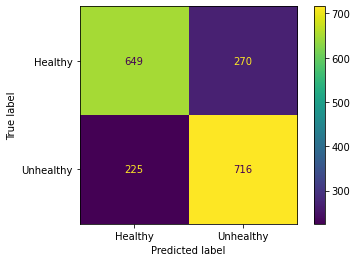

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metric

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_healthy_unhealthy.pdf')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_healthy_unhealthy.pdf')
plt.show()
  
print("Training accuracy: ", history.history['accuracy'][-1]*100)
print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)        

prob = model1.predict(x_test1,verbose = 2)
pred = (prob > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = prob[:, 0]
yhat_classes = pred[:, 0]
 
cm=metrics.confusion_matrix(y_test1,pred)
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test1,pred)
print('Accuracy: %f' % accuracy)
# sensitivity = tp(tp+fn)
#sensitivity = metrics.specificity_score(y_test1, pred)
# specificity = tn(tn+fp)
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity: %f' % specificity)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test1,pred)
print('Precision: %f' % precision)
# recall/sensitivity: tp / (tp + fn)
recall = metrics.recall_score(y_test1, pred)
print('Sensitivity: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test1, pred)
print('F1 score: %f' % f1)
# kappa
kappa = metrics.cohen_kappa_score(y_test1, pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = metrics.roc_auc_score(y_test1, prob)
print('ROC AUC: %f' % auc)

print("Total Samples Test: ", np.shape(y_test1)[0])
labels=["Healthy", "Unhealthy"]
cm=metrics.confusion_matrix(y_test1,pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)      
disp.plot()
plt.savefig('confusion_matrix_healthy_unhealthy.pdf')
print(cm)

0.8008699332430599


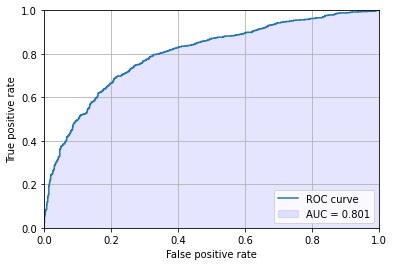

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras = model1.predict(x_test1).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test1, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)
plt.plot(fpr_keras, tpr_keras, label='ROC curve')
plt.fill_between(fpr_keras, tpr_keras, 0, color='blue', alpha=.1, label='AUC = {:.3f}'.format(auc_keras))
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('ROC_hea_unhea.pdf')

Actual = Healthy, Prediction = Healthy


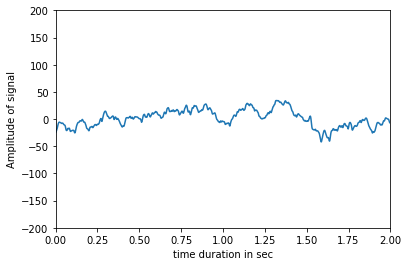

In [ ]:
labels=["Healthy", "Unhealthy"]
index=500
pred = model1.predict(x_test1)

real=y_test1
prediction=0
if (pred[index]>=0.5): prediction=1
act=labels[int(real[index])]
pr=labels[prediction]
print ("Actual = " + act + ", Prediction = " + pr)
plt.plot(np.arange(1024)/512 ,x_test1[index,:])
plt.xlabel("time duration in sec")
plt.ylabel("Amplitude of signal")
plt.axis([0, 2, -200, 200])
plt.show()